# Notes
## The csv files need to be downloaded first, and change their corresponding path.
## Please note that the hyperparameters presented in this example are for illustrative purposes only.

In [1]:
from src.model import *
from src.train import *

In [2]:
df1_file='./full_bins_features.csv'
df2_file='./Biolip_train_val_test_info.csv'



In [3]:
#### Hyperparameter for TopoDockQ ####

input_dim = 2646
neurons1 = 2048     
neurons2 = 2048  
neurons3 = 2048 
neurons4 = 2048 


lr=0.0005
batch_size=512

# num_epochs=1000
# patience=1000


num_epochs=30
patience=30


dropout=0.0

#### Hyperparameter for TopoDockQ ####


In [4]:
# Standard libraries
import argparse

# Numerical and data handling
import numpy as np
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Scikit-learn
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt



# lr=0.0005
# batch_size=512

# # num_epochs=1000
# # patience=1000


# num_epochs=20
# patience=20


# dropout=0.0



df1=pd.read_csv(df1_file)



df_train=df1[df1['data_class']!='test']



############################################################################################################
identical_columns_count = sum(df_train.nunique() == 1)

# print(f"Number of columns with all identical values: {identical_columns_count}")
#####


identical_columns =df_train.columns[df_train.nunique() == 1]

# Print the names of these columns
# print("Columns with all identical values:", identical_columns.tolist())

# Remove these columns from the DataFrame
df1= df1.drop(columns=identical_columns)
################################################################################################################


df2=pd.read_csv(df2_file)


df2=df2[['pdb_id','af_model_id','af_confidence','pdb2sql_DockQ','data_class']]

df1=pd.merge(df1,df2,on=['pdb_id','af_model_id','pdb2sql_DockQ','data_class'],how='inner')


df1_for_eval=df1
# print(df1.shape)



df_train=df1[df1['data_class']=='train']


df_val=df1[df1['data_class']=='valid']
df_test=df1[df1['data_class']=='test']

################################################################################################################


list_train=list(set(df_train['pdb_id'].to_list()))
list_val=list(set(df_val['pdb_id'].to_list()))
list_test=list(set(df_test['pdb_id'].to_list()))
# print(len(list_train),len(list_val),len(list_test))
for i in list_train:
    if (i in list_val) or (i in list_test):
        print(i)
for i in list_test:
    if (i in list_val) or (i in list_train):
        print(i)

################################################################################################################
import numpy as np
filtration_values = [f"{x:.1f}" if x.is_integer() else f"{x:.2f}".rstrip("0") for x in np.arange(2.0, 10.25, 0.25)]
filtration_values
# Generate persistent feature names for each filtration value
persistent_features = []
for filtration in filtration_values:
    persistent_features += [f"persistent_{filtration}_{str(i+1).zfill(2)}" for i in range(72)]  # Adjust 72 to the actual count if different

# Generate static feature names
static_features = [f"static_{str(i+1).zfill(2)}" for i in range(378)]  # Adjust 378 to the actual count if different

# Combine both lists
combined_feature_name_list = persistent_features + static_features


feature_name_list=[
                


                   'pdb2sql_DockQ'] +combined_feature_name_list

valid_columns = [col for col in feature_name_list if col in df_train.columns]

################################################################################################################


# Subset the DataFrame with the valid columns
df_train = df_train[valid_columns]
df_val = df_val[valid_columns]
df_test = df_test[valid_columns]

# print(df_train.shape,df_val.shape,df_test.shape)


####


def get_features_and_target(df):
    y = df['pdb2sql_DockQ'].values  # Select the 'pdb2sql_DockQ' column as the target
    X = df.drop(columns=['pdb2sql_DockQ']).values  # Drop the 'pdb2sql_DockQ' column to get the features
    return X, y




Epoch 1: Train RMSE: 0.7562303732433013, Train PCC: 0.13512173295021057, Validation RMSE: 0.26024329662323, Validation PCC: 0.7247430682182312
Validation loss improved; model saved at epoch 1
Validation PCC improved; model saved at epoch 1
Epoch 2: Train RMSE: 0.2171671018992742, Train PCC: 0.7623236179351807, Validation RMSE: 0.22000561654567719, Validation PCC: 0.7037999033927917
Validation loss improved; model saved at epoch 2
Epoch 3: Train RMSE: 0.17699404072977926, Train PCC: 0.8417882919311523, Validation RMSE: 0.25919777154922485, Validation PCC: 0.6800175309181213
Epoch 4: Train RMSE: 0.15200855883091086, Train PCC: 0.8825529217720032, Validation RMSE: 0.19161875545978546, Validation PCC: 0.769917905330658
Validation loss improved; model saved at epoch 4
Validation PCC improved; model saved at epoch 4
Epoch 5: Train RMSE: 0.12741165715149455, Train PCC: 0.9184303283691406, Validation RMSE: 0.20933206379413605, Validation PCC: 0.7274132966995239
Epoch 6: Train RMSE: 0.130299043

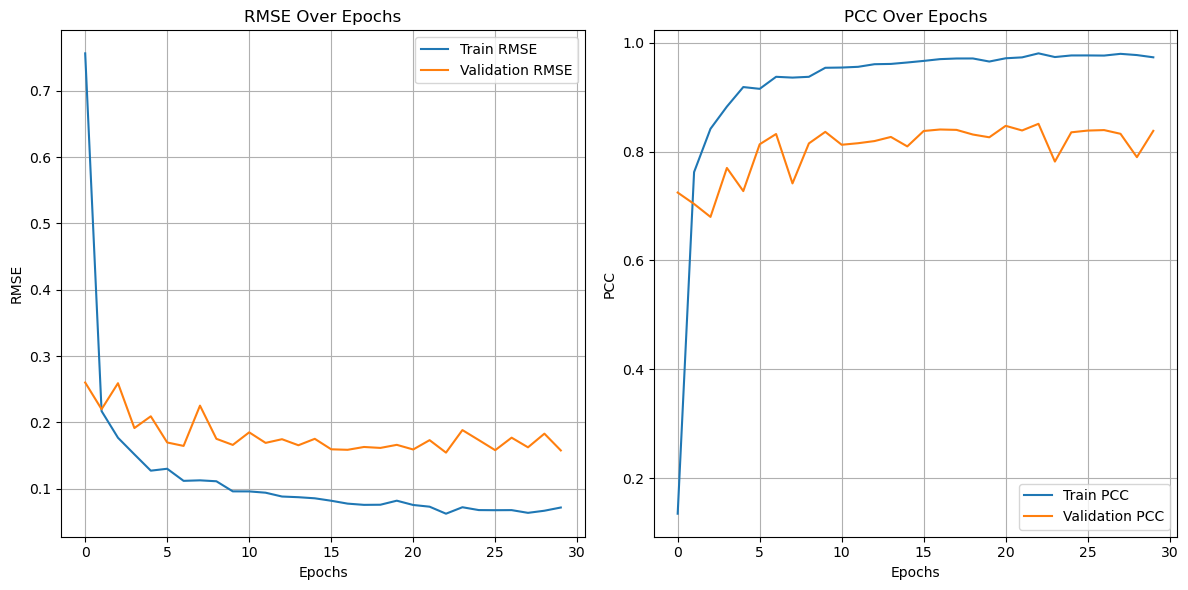

In [5]:
####
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Extract features and targets
X_train, y_train = get_features_and_target(df_train)
X_val, y_val = get_features_and_target(df_val)
X_test, y_test = get_features_and_target(df_test)



from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



# Convert arrays to PyTorch tensors and create datasets
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1000000)
test_loader = DataLoader(test_data, batch_size=1000000)

# #### Hyperparameter for TopoDockQ ####

# input_dim = 2646
# neurons1 = 2048     
# neurons2 = 2048  
# neurons3 = 2048 
# neurons4 = 2048 

# dropout = dropout   
# #### Hyperparameter for TopoDockQ ####

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model
model =TopoDockQ(input_dim, neurons1, neurons2, neurons3, neurons4,dropout).to(device)


        
        
# Set up optimizer with Adam
optimizer = optim.Adam(model.parameters(), lr=lr, eps=1e-08, amsgrad=False)  # Using Adam optimizer

# Set up learning rate scheduler
r_adjust = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1, last_epoch=-1)

# Train and evaluate the model
train_losses, val_losses, train_pccs, val_pccs= train_and_evaluate(
    model, train_loader, val_loader, optimizer, lr_scheduler=r_adjust,
    num_epochs=num_epochs, patience=patience, model_save_path="example_MLP_best_model.pth", pcc_model_save_path="example_MLP_best_pcc_model.pth"
)

                
##

torch.save(model.state_dict(), './example_MLP_1000epoch.pth')
                